In [104]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

from wordcloud import WordCloud

In [110]:
path = os.getcwd()
path_coal = os.path.join(path, 'data', 'coal.pkl')
path_solar = os.path.join(path, 'data', 'solar.pkl')
path_wind = os.path.join(path, 'data', 'wind.pkl')
path_to_ml_model = os.path.join(path, 'models', 'sentiment_classifier.pkl')
path_to_vectorizer = os.path.join(path, 'models', 'vectorizer.pkl')

In [111]:
df = pd.read_pickle(path_coal)
df2 = pd.read_pickle(path_solar)
df3 = pd.read_pickle(path_wind)

In [113]:
ENERGY = ['coal', 'solar', 'wind', 'gas', 'petro']
TWITTER_USER_REGEX = r'@([a-zA-Z0-9_]+)'
COLS_TO_DROP = ['timezone', 'place', 'language', 'cashtags', 'user_id', 'user_id_str', 'name', 'photos', 'video', 'retweet', 'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest']

In [114]:
with open(path_to_ml_model, 'rb') as f:
    clf = pickle.load(f)
with open(path_to_vectorizer, 'rb') as f:
    vectorizer = pickle.load(f)

In [115]:
def clean_text(df, column):
    # Regex for pattern matching
    unicode_regex_1 = r'(\\u[0-9A-Fa-f]+)'
    unicode_regex_2 = r'[^\x00-\x7f]'
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    # Unicode
    df[column] = df[column].str.replace(unicode_regex_1, r' ', regex=True)
    df[column] = df[column].str.replace(unicode_regex_2, r' ', regex=True)
    # Urls
    df[column] = df[column].str.replace(url_regex, 'url', regex=True)
    
    return df

In [116]:
df = df.reset_index(drop=True)
df = df.drop(columns=COLS_TO_DROP)
df['date'] = pd.to_datetime(df['date'])
df['tweet_clean'] = df['tweet']
df = clean_text(df, 'tweet_clean')

In [117]:
X_test = df['tweet_clean'].values
X_test_vectors = vectorizer.transform(X_test)
clf_prediction = clf.predict(X_test_vectors)
df['sentiment'] = pd.Series(clf_prediction)

In [118]:
df2 = df2.reset_index(drop=True)
df2 = df2.drop(columns=COLS_TO_DROP)
df2['date'] = pd.to_datetime(df2['date'])
df2['tweet_clean'] = df2['tweet']
df2 = clean_text(df2, 'tweet_clean')
X_test = df2['tweet_clean'].values
X_test_vectors = vectorizer.transform(X_test)
clf_prediction = clf.predict(X_test_vectors)
df2['sentiment'] = pd.Series(clf_prediction)

In [119]:
sentiment_count = df['sentiment'].value_counts()
sentiment_count

-1    6292
 0    3367
 1     300
Name: sentiment, dtype: int64

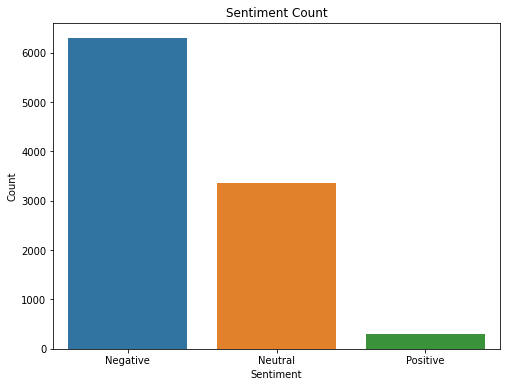

In [120]:
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_count.index, y=sentiment_count.values)
plt.title('Sentiment Count')
plt.xticks(ticks=[0, 1, 2], labels=labels)
plt.xlabel('Sentiment')
plt.ylabel('Count');

In [121]:
sentiment_count2 = df2['sentiment'].value_counts()
sentiment_count2

 0    5807
-1    2399
 1     798
Name: sentiment, dtype: int64

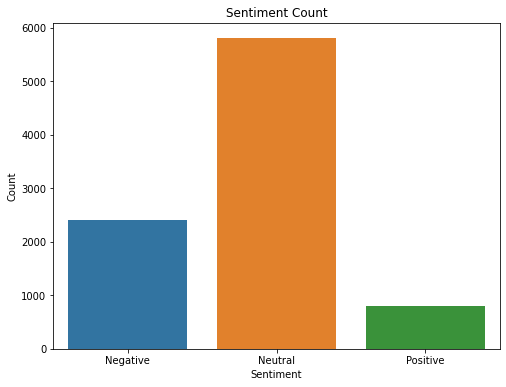

In [122]:

labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_count2.index, y=sentiment_count2.values)
plt.title('Sentiment Count')
plt.xticks(ticks=[0, 1, 2], labels=labels)
plt.xlabel('Sentiment')
plt.ylabel('Count');

In [125]:
df.columns

Index(['date', 'tweet', 'hashtags', 'username', 'day', 'hour', 'urls',
       'nlikes', 'nreplies', 'nretweets', 'reply_to', 'tweet_clean',
       'sentiment'],
      dtype='object')

In [126]:
df['energy'] = 'coal'
df2['energy'] = 'solar'

df_master = pd.concat([df, df2], ignore_index=True).reset_index(drop=True)


In [203]:
test = df_master.groupby('energy')['sentiment'].value_counts()
test = pd.DataFrame([test]).transpose()
test = test.rename(columns={'sentiment': 'count'})
test = test.reset_index()
test

,energy,sentiment,count
0,coal,-1,6292
1,coal,0,3367
2,coal,1,300
3,solar,0,5807
4,solar,-1,2399
5,solar,1,798


([<matplotlib.axis.XTick at 0x1fd8b709220>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

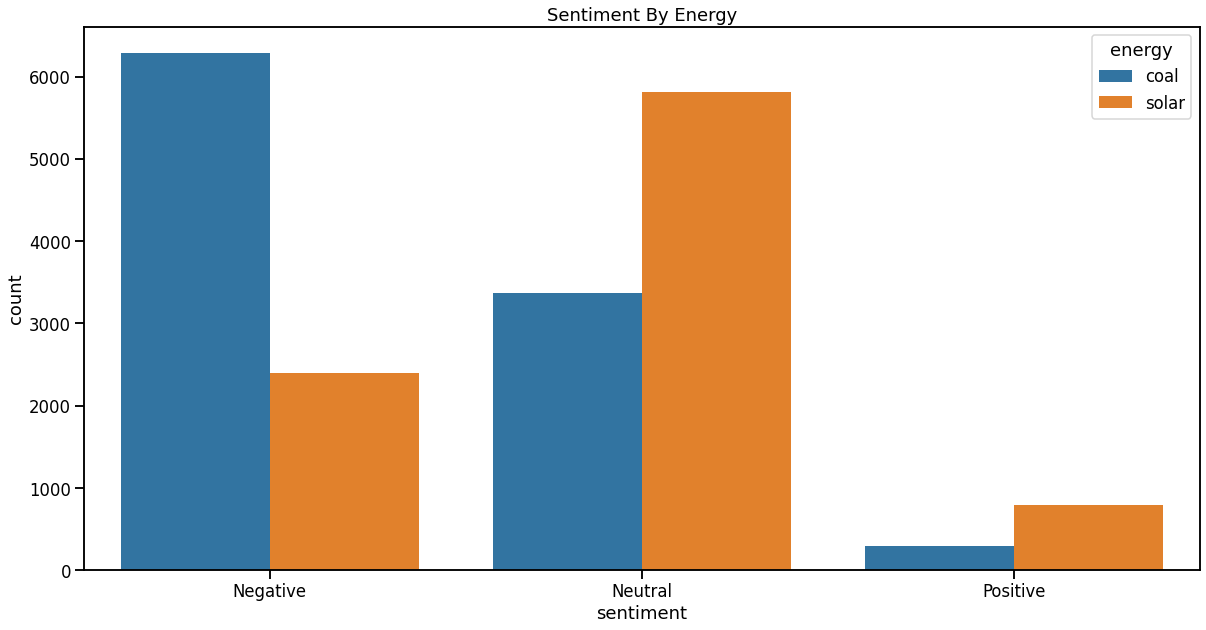

In [211]:
plt.figure(figsize=(20, 10))
sns.set_context('talk')
sns.barplot(x=test['sentiment'], y=test['count'], hue=test['energy'])
plt.title('Sentiment By Energy')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

In [214]:
df_master = df_master.sort_values('date')

<AxesSubplot:xlabel='date', ylabel='Count'>

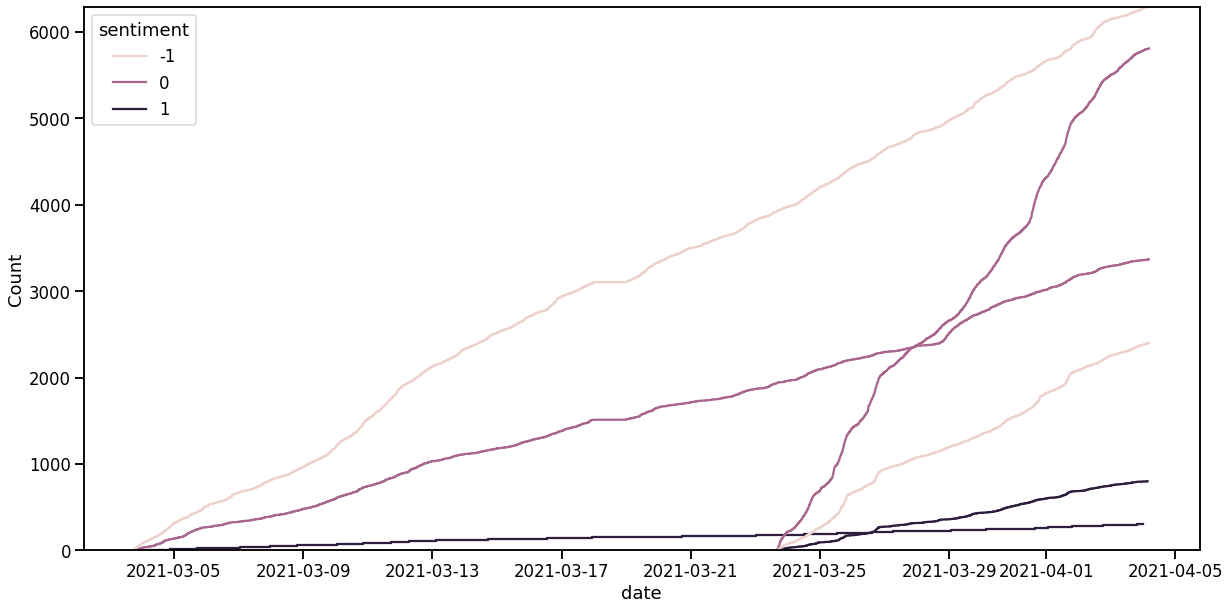

In [226]:
plt.figure(figsize=(20, 10))
sns.ecdfplot(data=df_master[df_master['energy'] == 'coal'], x='date', hue='sentiment', stat='count')
sns.ecdfplot(data=df_master[df_master['energy'] == 'solar'], x='date', hue='sentiment', stat='count')

In [227]:
COLS_TO_DROP = ['timezone', 'place', 'language', 'cashtags', 'user_id', 'user_id_str', 'name', 'photos', 'video', 'retweet', 'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest']

In [228]:
COLS_TO_DROP

['timezone',
 'place',
 'language',
 'cashtags',
 'user_id',
 'user_id_str',
 'name',
 'photos',
 'video',
 'retweet',
 'search',
 'near',
 'geo',
 'source',
 'user_rt_id',
 'user_rt',
 'retweet_id',
 'retweet_date',
 'translate',
 'trans_src',
 'trans_dest']